In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm

The DeepSTN model is here: https://ojs.aaai.org/index.php/AAAI/article/view/3892



In [4]:
!git clone https://github.com/panzheyi/ST-MetaNet.git

Cloning into 'ST-MetaNet'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 24.93 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [5]:
!unzip ./ST-MetaNet/flow-prediction/data.zip

Archive:  ./ST-MetaNet/flow-prediction/data.zip
  inflating: data/BJ_FEATURE.h5      
  inflating: data/BJ_FLOW.h5         
  inflating: data/BJ_GRAPH.h5        
  inflating: data/BJ_POI.h5          
  inflating: data/BJ_ROAD.h5         
  inflating: data/grids.txt          


In [6]:
import h5py

def read_h5(filename):

    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())[0]
        # Get the data
        data = list(f[a_group_key])
    
    return data

In [106]:
"""read flow data"""
flow_dir = "./data/BJ_FLOW.h5"
flow_data = read_h5(flow_dir)
flow_data = np.array(flow_data)
flow_data = flow_data.reshape(flow_data.shape[0]*flow_data.shape[1],
                              flow_data.shape[2],flow_data.shape[3],
                              flow_data.shape[4])

flow_data = flow_data.reshape(3600, 2, 32, 32)

flow_data.shape

(3600, 2, 32, 32)

- 3600 is number of time slices
- 32 is height of the grid
- 32 is width of the grid
- 2 is number of inflows/outflows

In [11]:
"""Read Coordinates data"""
with open('./data/grids.txt') as file:
    coordinates = file.read()
coordinates = np.array(eval(coordinates))

Here we use arcgis API to get the attribute (location type) of each coordinate in the grid so we can fuse it in the network along with the flow data

In [15]:
!pip install arcgis
from arcgis.geocoding import reverse_geocode

help(reverse_geocode)

Help on function reverse_geocode in module arcgis.geocoding._functions:

reverse_geocode(location, distance=None, out_sr=None, lang_code=None, return_intersection=False, for_storage=False, geocoder=None, feature_types=None, roof_top='street')
    The ``reverse_geocode`` operation determines the address at a particular
    x/y location. You pass the coordinates of a point location to the
    geocoding service, and the service returns the address that is
    closest to the location.
    
    =================== ====================================================
    **Argument**        **Description**
    ------------------- ----------------------------------------------------
    location            Required location input as list, dict (with or without SpatialReference),
                        or :class:`~arcgis.geometry.Point` object.
    ------------------- ----------------------------------------------------
    distance            optional float, radial distance in meters to
    

In [19]:
"""reverse each coordinate to get the location category"""
from arcgis.gis import GIS

gis = GIS()

POI_dict = {}

for grid_point, all_co in tqdm(enumerate(coordinates)):
    POI = []
    for co in all_co:
        try:
            poi = reverse_geocode([co[1], co[0]])
            poi = poi.get('address').get('Addr_type')
            POI.append(poi)
        except:
            pass
        
        if len(POI) != 0:
            POI_dict[grid_point] = POI

1024it [1:17:34,  4.55s/it]


We end up with three types of attributes for the locations (POI, Street and Locality)

In [27]:
"""get unique categories from the coordinates"""
unique_cat = []
for k, v in POI_dict.items():
    for cat in v:
        if cat not in unique_cat:
            unique_cat.append(cat)
print(unique_cat)

['StreetAddress', 'Locality', 'POI']


In [35]:
"""Build atribute matrix to be fused into the training"""
attr_data = np.zeros((1024, 3), dtype=float)
for i in range(1024):
    if POI_dict.get(i) is not None:
        attr_data[i, 0] = POI_dict.get(i).count('StreetAddress')
        attr_data[i, 1] = POI_dict.get(i).count('Locality')
        attr_data[i, 2] = POI_dict.get(i).count('POI')
attr_data = attr_data.reshape(3, 32, 32)
attr_data.shape

(3, 32, 32)

In [125]:
"""Modified after: https://github.com/FIBLAB/DeepSTN"""

from keras import backend as K
K.set_image_data_format('channels_first')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Activation, Dropout, BatchNormalization, AveragePooling2D, ZeroPadding2D, Multiply
from tensorflow.keras.layers import Lambda,Reshape,Concatenate,Add,Permute,TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

# Relu-BN-Conv2D 3x3
def conv_unit0(Fin,Fout,drop,H,W):
    unit_input=Input(shape=(Fin,H,W))
    
    unit_conv=Activation('relu')(unit_input)
    unit_conv=BatchNormalization()(unit_conv)
    unit_conv=Dropout(drop)(unit_conv)
    unit_output=Conv2D(filters=Fout,kernel_size=(3,3),padding="same")(unit_conv)
    unit_model=Model(inputs=unit_input,outputs=unit_output)
    print('kernel=(3,3)')
    return unit_model

# Relu-BN-Conv2D 1x1
def conv_unit1(Fin,Fout,drop,H,W):
    unit_input=Input(shape=(Fin,H,W))
    
    unit_conv=Activation('relu')(unit_input)
    unit_conv=BatchNormalization()(unit_conv)
    unit_conv=Dropout(drop)(unit_conv)
    unit_output=Conv2D(filters=Fout,kernel_size=(1,1),padding="same")(unit_conv)
    unit_model=Model(inputs=unit_input,outputs=unit_output)
    print('kernel=(1,1)')
    return unit_model

# efficient version of Res_plus
def Res_plus_E(name,F,Fplus,rate,drop,H,W):
    cl_input=Input(shape=(F,H,W))

    #normal channels
    cl_conv1A=conv_unit0(F,F-Fplus,drop,H,W)(cl_input)

    #separated channels
    if rate == 1:
        cl_conv1B=cl_input
    if rate !=1:
        cl_conv1B=AveragePooling2D(pool_size=(rate,rate),strides=(rate,rate),padding="valid")(cl_input)

    HR,WR=int(np.floor(H/rate)),int(np.floor(W/rate))
    cl_conv1B=Activation('relu')(cl_conv1B)
    cl_conv1B=BatchNormalization()(cl_conv1B)

    cl_conv1B=Conv2D(filters=Fplus,kernel_size=(1,1),use_bias=False,padding="same")(cl_conv1B)
    cl_conv1B=Reshape((Fplus,1,HR,WR),input_shape=(Fplus,HR,WR))(cl_conv1B)
    attention=Conv2D(filters=H*W,kernel_size=(HR,WR),use_bias=False,W_constraint=nonneg(),padding="valid")
    cl_conv1B=TimeDistributed(attention)(cl_conv1B)
    cl_conv1B=Reshape((Fplus,H,W),input_shape=(Fplus,H*W,1,1))(cl_conv1B)

    #merge
    cl_conv1=Concatenate(axis=1)([cl_conv1A,cl_conv1B])

    cl_conv2=conv_unit0(F,F,drop,H,W)(cl_conv1)

    cl_out=Add()([cl_input,cl_conv2])

    cl_model=Model(inputs=cl_input,outputs=cl_out,name=name)

    return cl_model

# new resdual block
def Res_plus(name,F,Fplus,rate,drop,H,W):
    cl_input=Input(shape=(F,H,W))
    
    cl_conv1A=conv_unit0(F,F-Fplus,drop,H,W)(cl_input)
    
    if rate == 1:
        cl_conv1B=cl_input
    if rate !=1:
        cl_conv1B=AveragePooling2D(pool_size=(rate,rate),strides=(rate,rate),padding="valid")(cl_input)
   
    cl_conv1B=Activation('relu')(cl_conv1B)
    cl_conv1B=BatchNormalization()(cl_conv1B) 
    
    plus_conv=Conv2D(filters=Fplus*H*W,kernel_size=(int(np.floor(H/rate)),int(np.floor(W/rate))),padding="valid")

    cl_conv1B=plus_conv(cl_conv1B)

    cl_conv1B=Reshape((Fplus,H,W))(cl_conv1B)

    cl_conv1=Concatenate(axis=1)([cl_conv1A,cl_conv1B])
    
    cl_conv2=conv_unit0(F,F,drop,H,W)(cl_conv1)
    
    cl_out=Add()([cl_input,cl_conv2])
    
    cl_model=Model(inputs=cl_input,outputs=cl_out,name=name)

    return cl_model

# normal residual block
def Res_normal(name,F,drop,H,W):
    cl_input=Input(shape=(F,H,W))
    
    cl_conv1=conv_unit0(F,F,drop,H,W)(cl_input)
   
    cl_conv2=conv_unit0(F,F,drop,H,W)(cl_conv1)
    
    cl_out=Add()([cl_input,cl_conv2])
    
    cl_model=Model(inputs=cl_input,outputs=cl_out,name=name)

    return cl_model
    
def cpt_slice(x, h1, h2):  
    return x[:,h1:h2,:,:]  

# transfer Time vector to a number (e.g. corresponding to filters = 1 in Conv2D)  
def T_trans(T,T_F,H,W):

    T_in=Input(shape=(T+7,H,W))
    T_mid=Conv2D(filters=T_F,kernel_size=(1,1),padding="same")(T_in)
    T_act=Activation('relu')(T_mid)
    T_fin=Conv2D(filters=1,kernel_size=(1,1),padding="same")(T_act)
    T_mul=Activation('relu')(T_fin)
    T_model=Model(inputs=T_in,outputs=T_mul)

    return T_model    
  
# transfer Time vector and PoI matrix to time-weighted PoI matrix    
def PT_trans(name,P_N,PT_F,T,T_F,H,W,isPT_F):
    if 1:
        poi_in=Input(shape=(P_N,H,W))
        # T_times/day + 7days/week 
        time_in=Input(shape=(T+7,H,W))
        
        P_N_list = [] 
        
        for i in range(2, P_N+1):
            if i == 2:
                if P_N >= i:
                    P_N_list.append(T_trans(T,T_F,H,W)(time_in)) 
                    P_N_list.append(T_trans(T,T_F,H,W)(time_in)) 
            else:
                if P_N >= i:
                    P_N_list.append(T_trans(T,T_F,H,W)(time_in)) 
         
        if P_N==1:
            T_x=T_trans(T,T_F,H,W)(time_in)
        else:
            T_x=Concatenate(axis=1)(P_N_list[:P_N])
            
        poi_time=Multiply()([poi_in,T_x])
        if isPT_F:
            poi_time=Conv2D(filters=PT_F,kernel_size=(1,1),padding="same")(poi_time)
            print('PT_F = YES')
        else:
            print('PT_F = NO')
        PT_model=Model(inputs=[poi_in,time_in],outputs=poi_time,name=name)

        return PT_model

    
def DeepSTN(H=21,W=12,channel=2,      #H-map_height W-map_width channel-map_channel
            c=3,p=4,t=4,              #c-closeness p-period t-trend
            pre_F=64,conv_F=64,R_N=2, #pre_F-prepare_conv_featrue conv_F-resnet_conv_featrue R_N-resnet_number
            is_plus=False,             #use ResPlus or mornal convolution
            is_plus_efficient=False,  #use the efficient version of ResPlus
            plus=8,rate=1,            #rate-pooling_rate
            is_pt=True,               #use PoI and Time or not
            P_N=9,T_F=28,PT_F=6,T=24, #P_N-poi_number T_F-time_feature PT_F-poi_time_feature T-T_times/day 
            drop=0,
            is_summary=True, #show detail
            lr=0.0002,
            kernel1=1, #kernel1 decides whether early-fusion uses conv_unit0 or conv_unit1, 1 recommended
            isPT_F=1): #isPT_F decides whether PT_model uses one more Conv after multiplying PoI and Time, 1 recommended
    
    all_channel = channel * (c+p+t)
            
    cut0 = int( 0 )
    cut1 = int( cut0 + channel*c )
    cut2 = int( cut1 + channel*p )
    cut3 = int( cut2 + channel*t )
       
    cpt_input=Input(shape=(all_channel,H,W))
            
    c_input=Lambda(cpt_slice,arguments={'h1':cut0,'h2':cut1})(cpt_input)
    p_input=Lambda(cpt_slice,arguments={'h1':cut1,'h2':cut2})(cpt_input)
    t_input=Lambda(cpt_slice,arguments={'h1':cut2,'h2':cut3})(cpt_input)
    
    c_out1=Conv2D(filters=pre_F,kernel_size=(1,1),padding="same")(c_input)
    p_out1=Conv2D(filters=pre_F,kernel_size=(1,1),padding="same")(p_input)
    t_out1=Conv2D(filters=pre_F,kernel_size=(1,1),padding="same")(t_input)
    
    if is_pt:
        poi_in=Input(shape=(P_N,H,W))
        # T_times/day + 7days/week 
        time_in=Input(shape=(T+7,H,W))

        PT_model=PT_trans('PT_trans',P_N,PT_F,T,T_F,H,W,isPT_F)
        
        poi_time=PT_model([poi_in,time_in])
 
        cpt_con1=Concatenate(axis=1)([c_out1,p_out1,t_out1,poi_time])
        if kernel1:
            cpt=conv_unit1(pre_F*3+PT_F*isPT_F+P_N*(not isPT_F),conv_F,drop,H,W)(cpt_con1)
        else:
            cpt=conv_unit0(pre_F*3+PT_F*isPT_F+P_N*(not isPT_F),conv_F,drop,H,W)(cpt_con1)
    
    else:
        cpt_con1=Concatenate(axis=1)([c_out1,p_out1,t_out1])
        if kernel1:
            cpt=conv_unit1(pre_F*3,conv_F,drop,H,W)(cpt_con1)
        else:
            cpt=conv_unit0(pre_F*3,conv_F,drop,H,W)(cpt_con1)  
     
    if is_plus:
        if is_plus_efficient:
            for i in range(R_N):
                cpt=Res_plus_E('Res_plus_'+str(i+1),conv_F,plus,rate,drop,H,W)(cpt)
        else:
            for i in range(R_N):
                cpt=Res_plus('Res_plus_'+str(i+1),conv_F,plus,rate,drop,H,W)(cpt)

    else:  
        for i in range(R_N):
            cpt=Res_normal('Res_normal_'+str(i+1),conv_F,drop,H,W)(cpt)

    cpt_conv2=Activation('relu')(cpt)
    cpt_out2=BatchNormalization()(cpt_conv2)
    cpt_conv1=Dropout(drop)(cpt_out2)
    cpt_conv1=Conv2D(filters=channel,kernel_size=(1, 1),padding="same")(cpt_conv1)
    cpt_out1=Activation('tanh')(cpt_conv1)
            
    if is_pt:
        DeepSTN_model=Model(inputs=[cpt_input,poi_in,time_in],outputs=cpt_out1)
    else:
        DeepSTN_model=Model(inputs=cpt_input,outputs=cpt_out1)

    DeepSTN_model.compile(loss='mse', optimizer=Adam(lr), metrics=[mae])
     
    return DeepSTN_model

In [126]:
class Params(object):
    batch_size = 32 
    map_height = 32 # spatial map height
    map_width = 32 # spatial map width
    closeness_sequence_length = 3 # length of closeness dependent sequence
    period_sequence_length = 4 # length of period dependent sequence
    trend_sequence_length =  4 # length of trend dependent sequence
    nb_flow = 2 # either "in" or "out" flow
    P_N=3 # P_N-poi_number T_F-time_feature PT_F-poi_time_feature T-T_times/day 
    PT_F=3
    T_F= 7*8
    num_of_filters = 64 
    num_of_residual_units = 12
    num_of_output = 2 #depth of predicted output map
    T = 24*1  # number of time intervals in one day
    T_closeness,T_period,T_trend = 1, T , T*7
    days_test = 14 # last 14 days for testing data
    len_test =  T * days_test
    
params = Params()

deepstn=DeepSTN(H=params.map_height,
                W=params.map_width,
                channel=params.nb_flow,
                c=params.closeness_sequence_length,
                p=params.period_sequence_length,                
                P_N=params.P_N,
                T_F=params.T_F,
                PT_F=params.PT_F,
                T=params.T)   

deepstn.summary()

PT_F = YES
kernel=(1,1)
kernel=(3,3)
kernel=(3,3)
kernel=(3,3)
kernel=(3,3)
Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_114 (InputLayer)          [(None, 22, 32, 32)] 0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 6, 32, 32)    0           input_114[0][0]                  
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 8, 32, 32)    0           input_114[0][0]                  
__________________________________________________________________________________________________
lambda_23 (Lambda)              (None, 8, 32, 32)    0           input_114[0][0]                  
_______________

The following are the amounts of inflows and outflows from the grid of the points

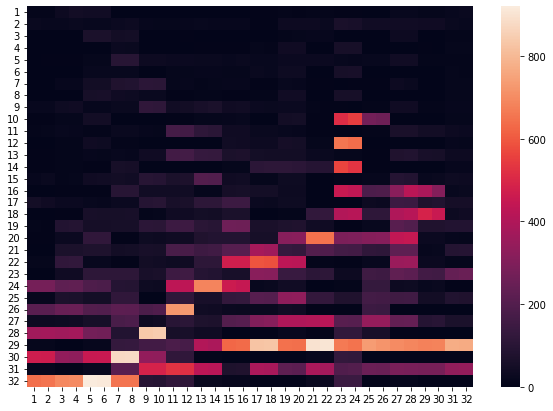

In [120]:
"""Amount of outflow in a certain time slice"""
one_time_slice_outflow = flow_data[1000, 0, :, :]

x_axis_labels = y_axis_labels = range(1,33)

plt.figure(figsize=(10,7))
ax = sns.heatmap(one_time_slice_outflow,xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

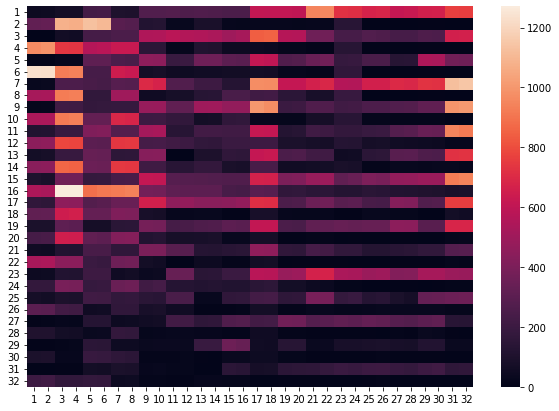

In [119]:
"""Amount of outflow in a certain time slice"""
one_time_slice_outflow = flow_data[1000, 1, :, :]

x_axis_labels = y_axis_labels = range(1,33)

plt.figure(figsize=(10,7))
ax = sns.heatmap(one_time_slice_outflow,xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

In [107]:
def load_data(len_test,len_closeness,len_period,len_trend,T_closeness,T_period,T_trend):
    
    #all_data=np.load(flow_data_dir)
    all_data = flow_data
    len_total,feature,map_height,map_width=all_data.shape
    maxi = np.max(all_data),
    mini = np.min(all_data)
    
    #for time
    time=np.arange(len_total,dtype=int)
    #hour
    time_hour=time%T_period
    matrix_hour=np.zeros([len_total,24,map_height,map_width])
    for i in range(len_total):
        matrix_hour[i,time_hour[i],:,:]=1
    #day
    time_day=(time//T_period)%7
    matrix_day=np.zeros([len_total,7,map_height,map_width])
    for i in range(len_total):
        matrix_day[i,time_day[i],:,:]=1
    #con
    matrix_T=np.concatenate((matrix_hour,matrix_day),axis=1)
    
    all_data=(2.0*all_data-(maxi+mini))/(maxi-mini)
    
    if len_trend>0:
        number_of_skip_hours=T_trend*len_trend
    elif len_period>0:
        number_of_skip_hours=T_period*len_period
    elif len_closeness>0:
        number_of_skip_hours=T_closeness*len_closeness  
    else:
        print("wrong")
    
    Y=all_data[number_of_skip_hours:len_total]

    if len_closeness>0:
        X_closeness=all_data[number_of_skip_hours-T_closeness:len_total-T_closeness]
        for i in range(len_closeness-1):
            X_closeness=np.concatenate((X_closeness,all_data[number_of_skip_hours-T_closeness*(2+i):len_total-T_closeness*(2+i)]),axis=1)
    if len_period>0:
        X_period=all_data[number_of_skip_hours-T_period:len_total-T_period]
        for i in range(len_period-1):
            X_period=np.concatenate((X_period,all_data[number_of_skip_hours-T_period*(2+i):len_total-T_period*(2+i)]),axis=1)
    if len_trend>0:
        X_trend=all_data[number_of_skip_hours-T_trend:len_total-T_trend]
        for i in range(len_trend-1):
            X_trend=np.concatenate((X_trend,all_data[number_of_skip_hours-T_trend*(2+i):len_total-T_trend*(2+i)]),axis=1)
    
    matrix_T=matrix_T[number_of_skip_hours:]
    
    X_closeness_train=X_closeness[:-len_test] 
    X_period_train=X_period[:-len_test] 
    X_trend_train=X_trend[:-len_test]  
    T_train=matrix_T[:-len_test] 
    X_closeness_test=X_closeness[-len_test:] 
    X_period_test=X_period[-len_test:] 
    X_trend_test=X_trend[-len_test:]          
    T_test=matrix_T[-len_test:]         
    
    X_train=[X_closeness_train,X_period_train,X_trend_train]
    X_test=[X_closeness_test,X_period_test,X_trend_test]
    Y_train=Y[:-len_test] 
    Y_test=Y[-len_test:] 

    len_train=X_closeness_train.shape[0]
    len_test=X_closeness_test.shape[0]
    print('len_train='+str(len_train))
    print('len_test ='+str(len_test ))
    
    #attr=np.load(poi_data_dir)
    attr = attr_data
    for i in range(attr.shape[0]):
        attr[i]=attr[i]/np.max(attr[i])
    P_train=np.repeat(attr.reshape(1,attr.shape[0],map_height,map_width),len_train,axis=0)
    P_test =np.repeat(attr.reshape(1,attr.shape[0],map_height,map_width),len_test ,axis=0)
    return X_train,T_train,P_train,Y_train,X_test,T_test,P_test,Y_test,maxi, mini

In [111]:
len_closeness = params.closeness_sequence_length
len_period = params.period_sequence_length
len_trend = params.trend_sequence_length
T = params.T  
T_closeness = params.T_closeness
T_period = params.T_period
T_trend = params.T_trend
days_test = params.days_test
len_test = params.len_test

X_train,T_train,P_train,Y_train,X_test,T_test,P_test,Y_test, maxi, mini = load_data(len_test,len_closeness,len_period,len_trend,T_closeness,T_period,T_trend)

len_train=2592
len_test =336


In [112]:
X_val = np.concatenate((X_train[0][-300:, :, :, :], 
                        X_train[1][-300:, :, :, :], 
                        X_train[2][-300:, :, :, :]), axis=1)

X_train=np.concatenate((X_train[0][:-300, :, :, :],
                        X_train[1][:-300, :, :, :],
                        X_train[2][:-300, :, :, :]),axis=1)

X_test =np.concatenate((X_test[0], 
                        X_test[1], 
                        X_test[2] ),axis=1)
    
index=np.arange(3)
P_train = P_train[:-300,index,:,:]
P_val = P_train[-300:,index,:,:]
P_test = P_test [:,index,:,:]

T_train = T_train[:-300,:,:,:]
T_val = T_train[-300:,:,:,:]

Y_train = Y_train[:-300, :, :, :]
Y_val = Y_train[-300:, :, :, :]

print(X_train.shape)
print(P_train.shape)
print(T_train.shape) 
print(X_val.shape)
print(P_val.shape)
print(T_val.shape)

(2292, 22, 32, 32)
(2292, 3, 32, 32)
(2292, 31, 32, 32)
(300, 22, 32, 32)
(300, 3, 32, 32)
(300, 31, 32, 32)


In [127]:
deepstn.fit([X_train,P_train,T_train], Y_train, 
            epochs=12, batch_size=32, 
            validation_data = ((X_val, P_val, T_val), Y_val))

Epoch 1/12
72/72 [==============================] - 61s 826ms/step - loss: 0.0303 - mae: 0.0916 - val_loss: 0.1103 - val_mae: 0.3058
Epoch 2/12
72/72 [==============================] - 58s 807ms/step - loss: 0.0065 - mae: 0.0534 - val_loss: 0.0496 - val_mae: 0.1930
Epoch 3/12
72/72 [==============================] - 59s 823ms/step - loss: 0.0044 - mae: 0.0447 - val_loss: 0.0362 - val_mae: 0.1497
Epoch 4/12
72/72 [==============================] - 59s 819ms/step - loss: 0.0035 - mae: 0.0397 - val_loss: 0.0244 - val_mae: 0.1074
Epoch 5/12
72/72 [==============================] - 60s 831ms/step - loss: 0.0031 - mae: 0.0369 - val_loss: 0.0238 - val_mae: 0.0957
Epoch 6/12
72/72 [==============================] - 59s 821ms/step - loss: 0.0028 - mae: 0.0348 - val_loss: 0.0253 - val_mae: 0.0929
Epoch 7/12
72/72 [==============================] - 59s 819ms/step - loss: 0.0027 - mae: 0.0341 - val_loss: 0.0209 - val_mae: 0.0795
Epoch 8/12
72/72 [==============================] - 59s 814ms/step - 

In [128]:
y_preds = deepstn.predict([X_test,P_test,T_test])
y_preds = (y_preds*(maxi- mini)+(maxi + mini))/2
y_true = (Y_test*(maxi- mini)+(maxi + mini))/2

In [129]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

RMSE:  60.699566
MAE:  37.671543


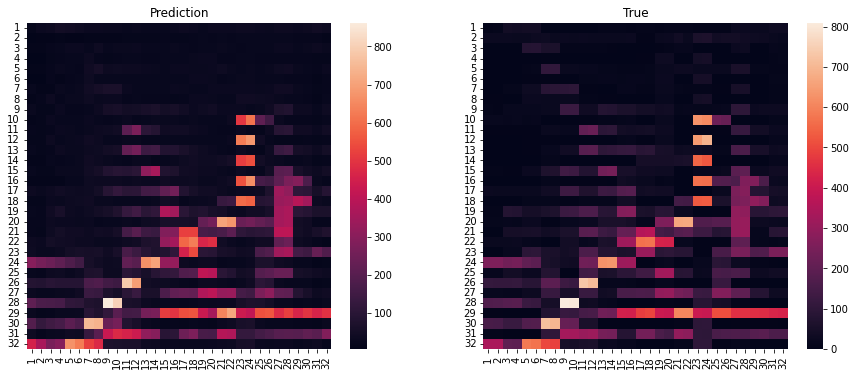

In [146]:
"""Prediction of inflow at certain time slice"""

import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow_true = y_true[0, 0, :, :]
one_time_slice_inflow_preds = y_preds[0, 0, :, :]
one_time_slice_inflow_preds = one_time_slice_inflow_preds.astype(int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

x_axis_labels = y_axis_labels = range(1,33)

sns.heatmap(one_time_slice_inflow_preds, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax1)

sns.heatmap(one_time_slice_inflow_true, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax2)

ax2.set_title('True')
ax1.set_title('Prediction')
plt.show()

In [132]:
!git clone https://github.com/css518/HSTGNN.git

Cloning into 'HSTGNN'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 44 (delta 7), reused 31 (delta 1), pack-reused 0
Unpacking objects: 100% (44/44), 3.29 MiB | 4.67 MiB/s, done.


In [138]:
!ls ./HSTGNN/data

bj_tfidf_poi.h5  cossimi_graph.npz


In [139]:
"""read flow data"""
dira = "./HSTGNN/data/bj_tfidf_poi.h5"
dira = read_h5(dira)
dira = np.array(dira)

dira.shape

(1024, 940)

In [143]:
dira = dira.reshape(940, 32, 32)
np.unique(dira)

(130462,)

# References

- https://github.com/FIBLAB/DeepSTN

- DeepSTN+: Context-aware Spatial-Temporal Neural Network for Crowd Flow Prediction in Metropolis. Ziqian Lin^, Jie Feng^, Ziyang Lu, Yong Li, and Depeng Jin. AAAI 2019.

- 